In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
path = '/content/drive/My Drive/Owkin/Owkin/'
os.chdir(path)

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import csv

import os
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# Extract data

In [ ]:
train_features_dir = Path(path) / "train_input" / "moco_features"
test_features_dir = Path(path) / "test_input" / "moco_features"

In [ ]:
npy_files = glob.glob(os.path.join(train_features_dir, '*.npy'))

X = []

for npy_file in npy_files:
    loaded_data = np.load(npy_file)
    x.append(loaded_data)

X = np.concatenate(X, axis=0)

# Remove metadata to only keep data
X = X[:,3:]

print("Data shape is: ", X.shape)

(344000, 2048)


In [ ]:
y = pd.read_csv(Path(path)  / "train_output.csv")

y = np.array(y)
y = y[:,1]

# We replicate the label of each image to the 1000 tiles extracted from the image
y = [value for value in y for _ in range(1000)]
y = np.array(y)

print("Label vector shape is: ", y.shape)

(344000,)


# Normalize data

In [ ]:
X = (X - np.mean(X)) / np.var(X)

# Split between train and test data for training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Shuffle X_train

indices = np.arange(len(x_train))

np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

# Create the model

In [ ]:
model = keras.Sequential()

model.add(layers.Reshape((2048, 1), input_shape=(2048,)))
model.add(layers.Conv1D(32, 8, activation='relu', strides=8))
model.add(layers.Conv1D(32, 8, activation='relu', strides=8))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2048, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 256, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 32)            8224      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 9537 (37.25 KB)
Trainable params: 9537 (37.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train model

In [ ]:
# Here, we explicitely split the dataset into batches for memory reasons

batch_size = 64
num_epochs = 4

metrics = []

# Loop over epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_metrics = []

    # Loop over batches
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Train the model on the current batch
        batch_metrics = model.train_on_batch(X_batch, y_batch)
        epoch_metrics.append(batch_metrics)

    metrics.append(epoch_metrics)

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4


In [ ]:
metrics = np.array(metrics)
metrics = metrics.reshape(-1, 2)

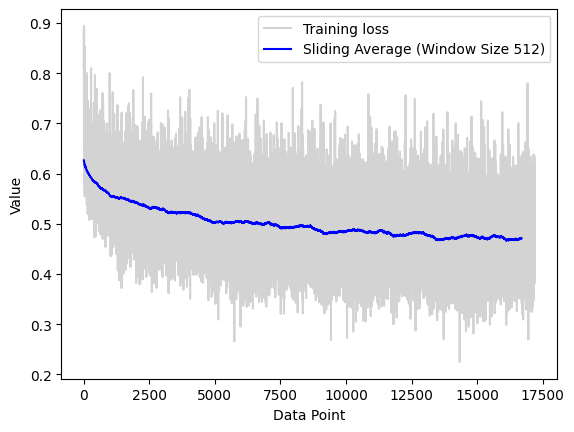

In [ ]:
window_size = 512

sliding_average = np.convolve(metrics[:,0], np.ones(window_size)/window_size, mode='valid')

plt.plot(metrics[:,0], label='Training loss', color='lightgray')
plt.plot(np.arange(len(sliding_average)), sliding_average, label=f'Sliding average (window size {window_size})', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()


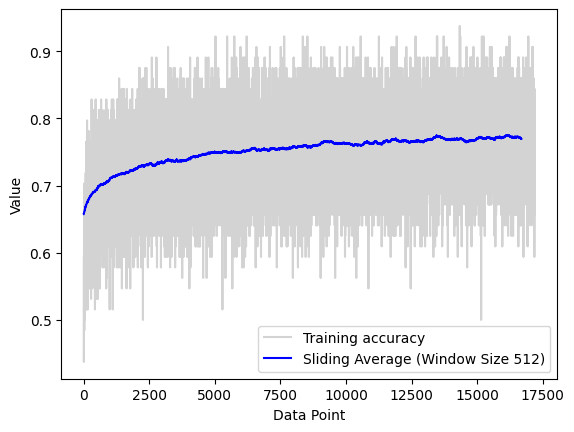

In [ ]:
sliding_average = np.convolve(metrics[:,1], np.ones(window_size)/window_size, mode='valid')

plt.plot(metrics[:,1], label='Training accuracy', color='lightgray')
plt.plot(np.arange(len(sliding_average)), sliding_average, label=f'Sliding Average (Window Size {window_size})', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()


# Perform inference on the test set created from Owkin's training set (with ground truth)

In [ ]:
# Inference on the test set

predictions = model.predict(X_test)

2150/2150 [==============================] - 4s 2ms/step


In [ ]:
# Turn probabilities into binary classes

predictions = (predictions > 0.5)*1

In [ ]:
# Compute accuracy

np.sum((predictions.T == y_test)*1)/len(predictions)

0.7613953488372093

# Perform inference on Owkin's test set

In [ ]:
npy_files = glob.glob(os.path.join(test_features_dir, '*.npy'))

X_test_owkin = []

for npy_file in npy_files:
    loaded_data = np.load(npy_file)
    X_test_owkin.append(loaded_data)

X_test_owkin = np.concatenate(X_test_owkin, axis=0)

# Remove metadata
X_test_owkin = X_test_owkin[:,3:]

In [ ]:
print("Data shape is: ", X_test_owkin.shape)

(149000, 2048)


In [ ]:
# Normalize values

X_test_owkin = (X_test_owkin - np.mean(X_test_owkin)) / np.var(C_test_owkin)

In [ ]:
# Inference on the data challenge test set

predictions_owkin = model.predict(X_test_owkin)

4657/4657 [==============================] - 10s 2ms/step


In [ ]:
pred_for_csv = []

# Convert output for each tile into output for each image
for i in range(0, len(predictions_owkin), 1000):
    pred_for_csv.append(np.mean(predictions_owkin[i:i+1000]))

In [ ]:
final_csv = []

file_list = os.listdir(test_features_dir)

for i in range(len(pred_for_csv)):
  final_csv.append((file_list[i], pred_for_csv[i]))

final_csv = np.array(final_csv)

In [ ]:
final_csv

array([['ID_004.npy', '0.65769273'],
       ['ID_003.npy', '0.33805865'],
       ['ID_008.npy', '0.39062715'],
       ['ID_010.npy', '0.27550116'],
       ['ID_009.npy', '0.42117366'],
       ['ID_011.npy', '0.2397976'],
       ['ID_017.npy', '0.37517065'],
       ['ID_015.npy', '0.23921302'],
       ['ID_022.npy', '0.46188635'],
       ['ID_027.npy', '0.22477105'],
       ['ID_034.npy', '0.40012005'],
       ['ID_029.npy', '0.47626448'],
       ['ID_030.npy', '0.21927398'],
       ['ID_036.npy', '0.31245893'],
       ['ID_038.npy', '0.49323955'],
       ['ID_043.npy', '0.20305447'],
       ['ID_044.npy', '0.30919215'],
       ['ID_047.npy', '0.34049127'],
       ['ID_051.npy', '0.26524112'],
       ['ID_065.npy', '0.36527276'],
       ['ID_060.npy', '0.408022'],
       ['ID_071.npy', '0.21754919'],
       ['ID_070.npy', '0.35137007'],
       ['ID_079.npy', '0.32034934'],
       ['ID_078.npy', '0.2512039'],
       ['ID_085.npy', '0.38206965'],
       ['ID_105.npy', '0.13796338'],
     

In [ ]:
final_csv_sorted = final_csv[final_csv[:, 0].argsort()]

In [ ]:
final_csv_sorted

array([['ID_003.npy', '0.33805865'],
       ['ID_004.npy', '0.65769273'],
       ['ID_008.npy', '0.39062715'],
       ['ID_009.npy', '0.42117366'],
       ['ID_010.npy', '0.27550116'],
       ['ID_011.npy', '0.2397976'],
       ['ID_015.npy', '0.23921302'],
       ['ID_017.npy', '0.37517065'],
       ['ID_022.npy', '0.46188635'],
       ['ID_027.npy', '0.22477105'],
       ['ID_029.npy', '0.47626448'],
       ['ID_030.npy', '0.21927398'],
       ['ID_034.npy', '0.40012005'],
       ['ID_036.npy', '0.31245893'],
       ['ID_038.npy', '0.49323955'],
       ['ID_043.npy', '0.20305447'],
       ['ID_044.npy', '0.30919215'],
       ['ID_047.npy', '0.34049127'],
       ['ID_051.npy', '0.26524112'],
       ['ID_060.npy', '0.408022'],
       ['ID_065.npy', '0.36527276'],
       ['ID_070.npy', '0.35137007'],
       ['ID_071.npy', '0.21754919'],
       ['ID_078.npy', '0.2512039'],
       ['ID_079.npy', '0.32034934'],
       ['ID_085.npy', '0.38206965'],
       ['ID_103.npy', '0.39934742'],
     

In [ ]:
csv_file = 'y_test_paul.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Sample ID', 'Target'])
    writer.writerows(final_csv_sorted)

print(f'final_csv has been exported to {csv_file}.')

final_csv has been exported to y_test_paul.csv.
